# Using SCProcessing Package for PDAC Preprocessing

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from SCProcessing import TrainSplit

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
path = "/home/aheydari/"
adata = sc.read_h5ad(path + 'data/PDAC_Data/PDAC_Atlas_Anndata.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 140250 × 15219
    obs: 'barcode_raw', 'celltype', 'sample_ID', 'sample_ID_celltype', 'TN', 'TN_manuscript', 'manuscript', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Size_Factor', 'TN_cluster_resolution_5', 'TN_assigned_cell_type', 'TN_assigned_cell_type_immune', 'TN_assigned_cell_type_immune_specific', 'TN_assigned_cell_type_immune_broad', 'cc', 'ccstage', 'Classifier_T_duct', 'Classifier_T_Fibroblast_only', 'Classifier_T_Fibroblast_Stellate'
    var: 'gene_ensembl_ID', 'gene_short_name', 'feature_in_nCells'
    uns: 'X_name', 'ccstage_colors', 'cds_version', 'citations', 'sample_ID_celltype_colors'
    obsm: 'X_aligned', 'X_pca', 'X_umap'

# Preprocessing

## Match the Broad Annotations with the [Manuscript](https://www.biorxiv.org/content/10.1101/2022.07.14.500096v2)

In [5]:
filtered_adata = adata[adata.obs["TN_assigned_cell_type_immune_broad"]!="NA"]

In [6]:
filtered_adata.obs.replace(to_replace="Epithelial_unspecified", value="Epithelial_cancer", inplace=True)

filtered_adata.obs.TN_assigned_cell_type_immune_broad.value_counts()

Immune_myeloid            31862
Epithelial_cancer         31467
Immune_lymphoid_T cell    19655
Epithelial_normal         10237
Endothelial                9218
Fibroblast                 8960
Stellate                   7777
Immune_lymphoid_B cell     7474
Acinar                     4100
RBC                         721
Endocrine                   665
Name: TN_assigned_cell_type_immune_broad, dtype: int64

/home/aheydari/data/miniconda3/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


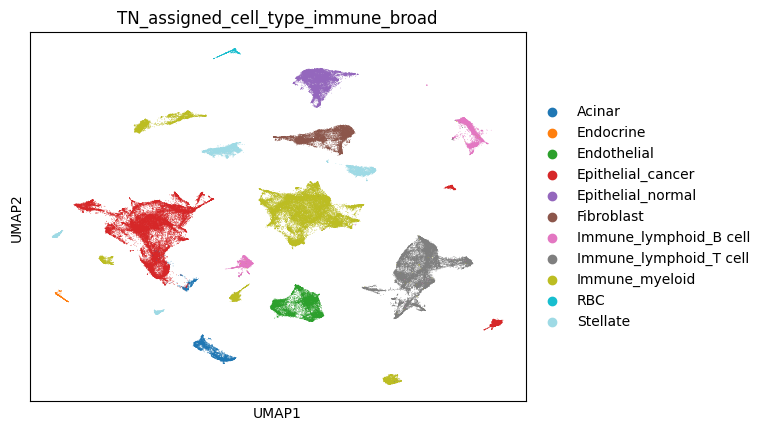

In [7]:
sc.pl.umap(filtered_adata, 
          color="TN_assigned_cell_type_immune_broad",
          palette= "tab20")

## Get HVGs

In [8]:
sc.pp.highly_variable_genes(filtered_adata, n_top_genes=5000, flavor='seurat_v3')

In [9]:
hvg_filtered_adata = filtered_adata[:, filtered_adata.var.highly_variable]
hvg_filtered_adata

View of AnnData object with n_obs × n_vars = 132136 × 5000
    obs: 'barcode_raw', 'celltype', 'sample_ID', 'sample_ID_celltype', 'TN', 'TN_manuscript', 'manuscript', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Size_Factor', 'TN_cluster_resolution_5', 'TN_assigned_cell_type', 'TN_assigned_cell_type_immune', 'TN_assigned_cell_type_immune_specific', 'TN_assigned_cell_type_immune_broad', 'cc', 'ccstage', 'Classifier_T_duct', 'Classifier_T_Fibroblast_only', 'Classifier_T_Fibroblast_Stellate'
    var: 'gene_ensembl_ID', 'gene_short_name', 'feature_in_nCells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_name', 'ccstage_colors', 'cds_version', 'citations', 'sample_ID_celltype_colors', 'TN_assigned_cell_type_immune_broad_colors', 'hvg'
    obsm: 'X_aligned', 'X_pca', 'X_umap'

In [10]:
hvg_filtered_adata.obs["celltype"] = hvg_filtered_adata.obs.TN_assigned_cell_type_immune_broad
num_unique_celltypes = len(hvg_filtered_adata.obs["celltype"].unique())
print(f"# of Unique Cell Types (11 in the manuscript): {num_unique_celltypes}")
hvg_filtered_adata.obs["cluster"] = LabelEncoder().fit_transform(hvg_filtered_adata.obs.celltype)
hvg_filtered_adata.obs

/tmp/ipykernel_569771/3617795262.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  hvg_filtered_adata.obs["celltype"] = hvg_filtered_adata.obs.TN_assigned_cell_type_immune_broad


# of Unique Cell Types (11 in the manuscript): 11


,barcode_raw,celltype,sample_ID,sample_ID_celltype,TN,TN_manuscript,manuscript,nCount_RNA,nFeature_RNA,percent.mt,...,TN_assigned_cell_type,TN_assigned_cell_type_immune,TN_assigned_cell_type_immune_specific,TN_assigned_cell_type_immune_broad,cc,ccstage,Classifier_T_duct,Classifier_T_Fibroblast_only,Classifier_T_Fibroblast_Stellate,cluster
AAACGAAAGTGGAAAG-1_PDAC_TISSUE_1_Steele,AAACGAAAGTGGAAAG-1,Immune_myeloid,PDAC_TISSUE_1,NA,T,T_Steele,Steele,501.0,269,12.574850,...,9,9,Neutrophil,Immune_myeloid,6.042028,NA,NA,NA,NA,8
AAACGCTGTAATCAGA-1_PDAC_TISSUE_1_Steele,AAACGCTGTAATCAGA-1,Acinar,PDAC_TISSUE_1,NA,T,T_Steele,Steele,835.0,158,4.431138,...,Acinar,Acinar,Acinar,Acinar,5.836493,G1.S,NA,NA,NA,0
AAAGAACCATTAAAGG-1_PDAC_TISSUE_1_Steele,AAAGAACCATTAAAGG-1,Immune_myeloid,PDAC_TISSUE_1,NA,T,T_Steele,Steele,12735.0,4047,3.682764,...,Macrophage,Macrophage,Macrophage,Immune_myeloid,1.513494,S,NA,NA,NA,8
AAAGGATTCGGCTTGG-1_PDAC_TISSUE_1_Steele,AAAGGATTCGGCTTGG-1,Immune_lymphoid_T cell,PDAC_TISSUE_1,NA,T,T_Steele,Steele,5654.0,2201,3.289706,...,NK/CTL,NK/CTL,NK/CTL,Immune_lymphoid_T cell,2.331229,G1.S,NA,NA,NA,7
AAAGGGCAGTAGCAAT-1_PDAC_TISSUE_1_Steele,AAAGGGCAGTAGCAAT-1,Immune_myeloid,PDAC_TISSUE_1,NA,T,T_Steele,Steele,20290.0,4773,5.864958,...,Macrophage,Macrophage,Macrophage,Immune_myeloid,3.899484,NA,NA,NA,NA,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
attagtatagcgcgttat_PDAC2_Bernard,attagtatagcgcgttat,Immune_myeloid,PDAC2,NA,T,T_Bernard,Bernard,450.0,270,0.000000,...,Macrophage,Macrophage,Macrophage,Immune_myeloid,5.902988,NA,NA,NA,NA,8
ccacgcgtacagaccttc_PDAC2_Bernard,ccacgcgtacagaccttc,Immune_myeloid,PDAC2,NA,T,T_Bernard,Bernard,448.0,272,0.000000,...,Macrophage,Macrophage,Macrophage,Immune_myeloid,2.613766,NA,NA,NA,NA,8
gctcccagtaaaggtagg_PDAC2_Bernard,gctcccagtaaaggtagg,Epithelial_cancer,PDAC2,NA,T,T_Bernard,Bernard,448.0,295,0.000000,...,Epithelial_transitional,Epithelial_transitional,Epithelial_cancer,Epithelial_cancer,5.849081,G2,Classical,NA,NA,3
tgaatttgcggtgtacag_PDAC2_Bernard,tgaatttgcggtgtacag,Epithelial_cancer,PDAC2,NA,T,T_Bernard,Bernard,446.0,291,0.000000,...,Epithelial_transitional,Epithelial_transitional,Epithelial_cancer,Epithelial_cancer,5.544197,NA,dual_positive,NA,NA,3


In [11]:
hvg_filtered_adata.obs.cluster

AAACGAAAGTGGAAAG-1_PDAC_TISSUE_1_Steele    8
AAACGCTGTAATCAGA-1_PDAC_TISSUE_1_Steele    0
AAAGAACCATTAAAGG-1_PDAC_TISSUE_1_Steele    8
AAAGGATTCGGCTTGG-1_PDAC_TISSUE_1_Steele    7
AAAGGGCAGTAGCAAT-1_PDAC_TISSUE_1_Steele    8
                                          ..
attagtatagcgcgttat_PDAC2_Bernard           8
ccacgcgtacagaccttc_PDAC2_Bernard           8
gctcccagtaaaggtagg_PDAC2_Bernard           3
tgaatttgcggtgtacag_PDAC2_Bernard           3
gcgaatgtggtggccgtt_PDAC2_Bernard           8
Name: cluster, Length: 132136, dtype: int64

# Split Data to Train/Test

## Pass in the object to `TrainSplit` class

So first, we want to make sure that we create an object of `TrainSplit` class, so that we could call all of its method. Here is the usage of this class:

`__init__(self, data, trainNumber, validationNumber, testNumber, balancedSplit:bool=True, randSeed:int=0, clusterRes=None, savePath = None)`

Where `trainNumber` is the number of training samples, `testNumber` and `validNumber` are the number of testing and validation. Note that if you choose balance split (recommended), i.e. `balanceSplit=True`, then these numbers may be slightly off becuase the proportions are being considered. If clustering is not done already, `clusterRes` is the resolution of the clustering that will be done. 

In [12]:
obj = TrainSplit(adata = hvg_filtered_adata, trainNumber = 105708, testNumber = 26427, validationNumber=0, balancedSplit=True, clusterRes = None)

### Clustering Information

If the data is already clustered, we only need to get the cluster ratios for a balance split. Make sure that the `scanpy` object has an attribute under `obs` that is called `cluster`, e.g. `adata.obs["cluster"]` exists. If data is ***not clustered***, then you can run `obj.Cluster()` first, and then continue on exactly the same.

In [13]:
## IF CLUSTERING IS ALREADY DONE! 
obj.Cluster_ratios()

==> Saving cluster ratios:
    -> Number of clusters: 11
-><- Saved cluster ratios to object attributes


In [14]:
obj.__dict__

{'sc_raw': AnnData object with n_obs × n_vars = 132136 × 5000
     obs: 'barcode_raw', 'celltype', 'sample_ID', 'sample_ID_celltype', 'TN', 'TN_manuscript', 'manuscript', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Size_Factor', 'TN_cluster_resolution_5', 'TN_assigned_cell_type', 'TN_assigned_cell_type_immune', 'TN_assigned_cell_type_immune_specific', 'TN_assigned_cell_type_immune_broad', 'cc', 'ccstage', 'Classifier_T_duct', 'Classifier_T_Fibroblast_only', 'Classifier_T_Fibroblast_Stellate', 'cluster'
     var: 'gene_ensembl_ID', 'gene_short_name', 'feature_in_nCells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'X_name', 'ccstage_colors', 'cds_version', 'citations', 'sample_ID_celltype_colors', 'TN_assigned_cell_type_immune_broad_colors', 'hvg'
     obsm: 'X_aligned', 'X_pca', 'X_umap',
 'train_cells': 105708,
 'valid_cells': 0,
 'test_cells': 26427,
 'balanced_split': True,
 'split_seed': 0,
 'cluster_res': None,
 'cells_count': 13213

## Split!

In [15]:
obj.Split()

INFO:root:    -> Cluster Ratios exist
INFO:root:    -> Starting a *balanced* split


==> Splitting:
    -> Starting a *balanced* split
-><- Splitting done
Splitting took 1.584324836730957 seconds


Now inspect the orginal data to make sure we have an attribute called `split`!

In [16]:
obj.sc_raw.obs[obj.sc_raw.obs['split']=='test']

,barcode_raw,celltype,sample_ID,sample_ID_celltype,TN,TN_manuscript,manuscript,nCount_RNA,nFeature_RNA,percent.mt,...,TN_assigned_cell_type_immune,TN_assigned_cell_type_immune_specific,TN_assigned_cell_type_immune_broad,cc,ccstage,Classifier_T_duct,Classifier_T_Fibroblast_only,Classifier_T_Fibroblast_Stellate,cluster,split
AACAACCGTCTTCAAG-1_PDAC_TISSUE_1_Steele,AACAACCGTCTTCAAG-1,Immune_myeloid,PDAC_TISSUE_1,NA,T,T_Steele,Steele,1539.0,712,3.248863,...,9,Neutrophil,Immune_myeloid,5.989288,NA,NA,NA,NA,8,test
AACAAGATCCATGAGT-1_PDAC_TISSUE_1_Steele,AACAAGATCCATGAGT-1,Immune_myeloid,PDAC_TISSUE_1,NA,T,T_Steele,Steele,14401.0,3923,5.360739,...,Neutrophil,Neutrophil,Immune_myeloid,1.478529,NA,NA,NA,NA,8,test
AACCACACACTTGAAC-1_PDAC_TISSUE_1_Steele,AACCACACACTTGAAC-1,Immune_myeloid,PDAC_TISSUE_1,NA,T,T_Steele,Steele,17829.0,4280,6.803522,...,Macrophage,Macrophage,Immune_myeloid,6.253710,G2.M,NA,NA,NA,8,test
AACCTGACATCTCATT-1_PDAC_TISSUE_1_Steele,AACCTGACATCTCATT-1,Immune_lymphoid_T cell,PDAC_TISSUE_1,NA,T,T_Steele,Steele,7986.0,2719,6.699224,...,NK/CTL,NK/CTL,Immune_lymphoid_T cell,2.340513,G1.S,NA,NA,NA,7,test
AACCTTTCAACCGTGC-1_PDAC_TISSUE_1_Steele,AACCTTTCAACCGTGC-1,Acinar,PDAC_TISSUE_1,NA,T,T_Steele,Steele,1233.0,176,4.055150,...,Acinar,Acinar,Acinar,5.804894,G1.S,NA,NA,NA,0,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gcttgttatttcaacagc_PDAC2_Bernard,gcttgttatttcaacagc,Epithelial_cancer,PDAC2,NA,T,T_Bernard,Bernard,451.0,295,0.000000,...,Epithelial_cancer,Epithelial_cancer,Epithelial_cancer,0.064646,NA,Classical,NA,NA,3,test
attagtatagcgcgttat_PDAC2_Bernard,attagtatagcgcgttat,Immune_myeloid,PDAC2,NA,T,T_Bernard,Bernard,450.0,270,0.000000,...,Macrophage,Macrophage,Immune_myeloid,5.902988,NA,NA,NA,NA,8,test
gctcccagtaaaggtagg_PDAC2_Bernard,gctcccagtaaaggtagg,Epithelial_cancer,PDAC2,NA,T,T_Bernard,Bernard,448.0,295,0.000000,...,Epithelial_transitional,Epithelial_cancer,Epithelial_cancer,5.849081,G2,Classical,NA,NA,3,test
tgaatttgcggtgtacag_PDAC2_Bernard,tgaatttgcggtgtacag,Epithelial_cancer,PDAC2,NA,T,T_Bernard,Bernard,446.0,291,0.000000,...,Epithelial_transitional,Epithelial_cancer,Epithelial_cancer,5.544197,NA,dual_positive,NA,NA,3,test


In [17]:
obj.sc_raw.obs[obj.sc_raw.obs['split']=='train']

,barcode_raw,celltype,sample_ID,sample_ID_celltype,TN,TN_manuscript,manuscript,nCount_RNA,nFeature_RNA,percent.mt,...,TN_assigned_cell_type_immune,TN_assigned_cell_type_immune_specific,TN_assigned_cell_type_immune_broad,cc,ccstage,Classifier_T_duct,Classifier_T_Fibroblast_only,Classifier_T_Fibroblast_Stellate,cluster,split
AAACGAAAGTGGAAAG-1_PDAC_TISSUE_1_Steele,AAACGAAAGTGGAAAG-1,Immune_myeloid,PDAC_TISSUE_1,NA,T,T_Steele,Steele,501.0,269,12.574850,...,9,Neutrophil,Immune_myeloid,6.042028,NA,NA,NA,NA,8,train
AAACGCTGTAATCAGA-1_PDAC_TISSUE_1_Steele,AAACGCTGTAATCAGA-1,Acinar,PDAC_TISSUE_1,NA,T,T_Steele,Steele,835.0,158,4.431138,...,Acinar,Acinar,Acinar,5.836493,G1.S,NA,NA,NA,0,train
AAAGAACCATTAAAGG-1_PDAC_TISSUE_1_Steele,AAAGAACCATTAAAGG-1,Immune_myeloid,PDAC_TISSUE_1,NA,T,T_Steele,Steele,12735.0,4047,3.682764,...,Macrophage,Macrophage,Immune_myeloid,1.513494,S,NA,NA,NA,8,train
AAAGGATTCGGCTTGG-1_PDAC_TISSUE_1_Steele,AAAGGATTCGGCTTGG-1,Immune_lymphoid_T cell,PDAC_TISSUE_1,NA,T,T_Steele,Steele,5654.0,2201,3.289706,...,NK/CTL,NK/CTL,Immune_lymphoid_T cell,2.331229,G1.S,NA,NA,NA,7,train
AAAGGGCAGTAGCAAT-1_PDAC_TISSUE_1_Steele,AAAGGGCAGTAGCAAT-1,Immune_myeloid,PDAC_TISSUE_1,NA,T,T_Steele,Steele,20290.0,4773,5.864958,...,Macrophage,Macrophage,Immune_myeloid,3.899484,NA,NA,NA,NA,8,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ccgatgccgtaatgaatt_PDAC2_Bernard,ccgatgccgtaatgaatt,Epithelial_cancer,PDAC2,NA,T,T_Bernard,Bernard,458.0,228,0.000000,...,Epithelial_transitional,Epithelial_cancer,Epithelial_cancer,6.269732,G2.M,Classical,NA,NA,3,train
taatagccacgcttcttg_PDAC2_Bernard,taatagccacgcttcttg,Epithelial_cancer,PDAC2,NA,T,T_Bernard,Bernard,453.0,259,0.000000,...,Epithelial_transitional,Epithelial_cancer,Epithelial_cancer,3.421368,NA,Classical,NA,NA,3,train
caggagtctagcgcgcgg_PDAC2_Bernard,caggagtctagcgcgcgg,Immune_lymphoid_T cell,PDAC2,NA,T,T_Bernard,Bernard,451.0,311,0.000000,...,T cell,T cell,Immune_lymphoid_T cell,1.884844,G2,NA,NA,NA,7,train
ccgtaagtttcacgcata_PDAC2_Bernard,ccgtaagtttcacgcata,Epithelial_cancer,PDAC2,NA,T,T_Bernard,Bernard,451.0,213,0.000000,...,Epithelial_transitional,Epithelial_cancer,Epithelial_cancer,5.825402,NA,dual_positive,NA,NA,3,train


## Save the new `scanpy` object

Now we can save the object to a `h5ad` file. If we do not provide a path, the object is saved to a directory `./TrainSplitData` with a JSON of the hyperparameters, and the actual `h5ad` file containing the object. Alternatively, you can provide a path initially when you make the `TrainSplit` object under `savePath`, but this is not necessary. 

In [18]:
obj.Save(save_path="/home/aheydari/data/NACT_Data/UseForTraining-March29th2022/")

... storing 'cluster' as categorical


==> Saving processed data:
    -> trying to save in: /home/aheydari/data/NACT_Data/UseForTraining-March29th2022/
    -> Saving data and parameters to folder /home/aheydari/data/NACT_Data/UseForTraining-March29th2022/TrainTestSplit.h5ad
-><- Saving done.
